In [66]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image


In [67]:
from shapes_loader import *

dataset_path = './datasets/synthetic_shapes_v6/'

train_loader = DataLoader(ShapesLoader(mode='validation',dataset_path='./datasets/synthetic_shapes_v6/'),batch_size=64,shuffle=True,collate_fn=collate_fn)


Looking into dataset dir for validation data
Loading images and points from draw_lines
Loading images and points from draw_polygon
Loading images and points from draw_checkerboard
Loading images and points from gaussian_noise
Loading images and points from draw_ellipses
Loading images and points from draw_stripes
Loading images and points from draw_star
Loading images and points from draw_cube
Loading images and points from draw_multiple_polygons
Finished loading the synthetic shapes dataset. Took:2.792 s


> <ipython-input-69-d50a0bf19111>(4)<module>()->None
-> fig=plt.figure(figsize=(8, 8))
(Pdb) c


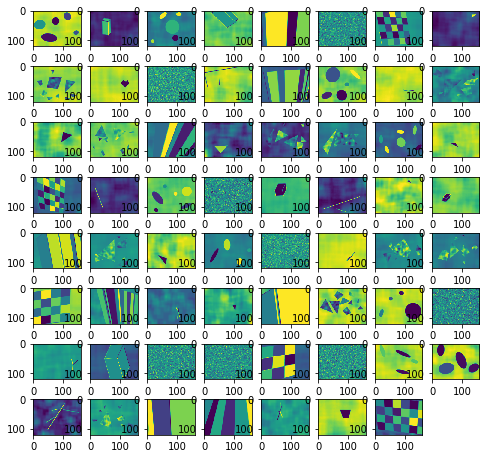

> <ipython-input-69-d50a0bf19111>(3)<module>()->None
-> pdb.set_trace()
(Pdb) q


BdbQuit: 

In [69]:

for batch_idx, (imgs,pts,didx) in enumerate(train_loader):
    pdb.set_trace()
    fig=plt.figure(figsize=(8, 8))
    columns = 8
    rows = 8
    
    for i in range(1, columns*rows):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
        
    plt.show()

    
    

In [70]:
DEVICE='cuda'
val_loader = DataLoader(ShapesLoader(mode='validation',dataset_path='./datasets/synthetic_shapes_v6/'),
                          batch_size=64,collate_fn=collate_fn,shuffle=True)

#first epoch model
model = torch.load('Fri Nov  9 15:54:21 2018/e_0_a_177.1913.model')
#model at epoch 146
#model = torch.load('Fri Nov  9 15:54:21 2018/e_146_a_13.2235.model')


model = model.to(DEVICE)

model.eval()


optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-6)

criterion = nn.Softmax(dim=1) #reduction='elementwise_sum')

threshold = 0.02



Looking into dataset dir for validation data
Loading images and points from draw_lines
Loading images and points from draw_polygon
Loading images and points from draw_checkerboard
Loading images and points from gaussian_noise
Loading images and points from draw_ellipses
Loading images and points from draw_stripes
Loading images and points from draw_star
Loading images and points from draw_cube
Loading images and points from draw_multiple_polygons
Finished loading the synthetic shapes dataset. Took:0.569 s


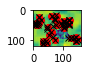

draw_multiple_polygons_123


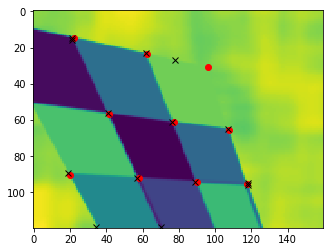

draw_checkerboard_36


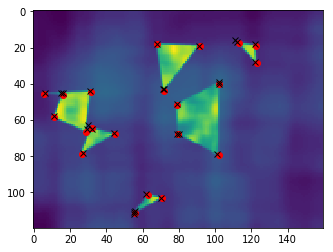

draw_multiple_polygons_76


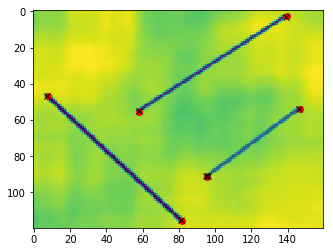

draw_lines_119


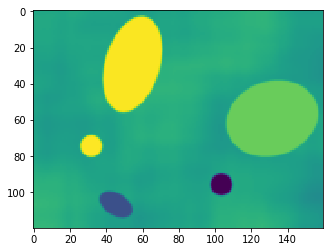

draw_ellipses_95


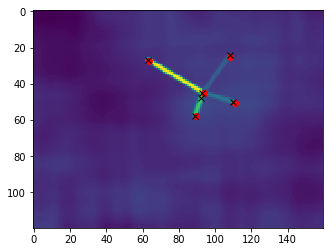

draw_star_179


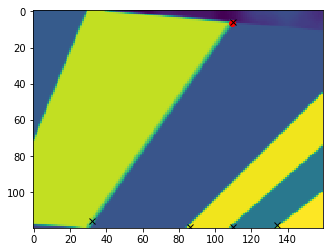

draw_stripes_106


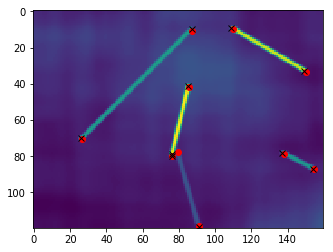

draw_lines_70


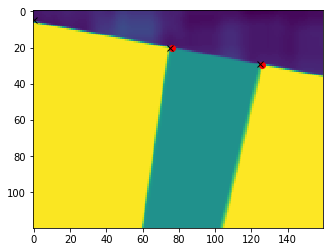

draw_stripes_33


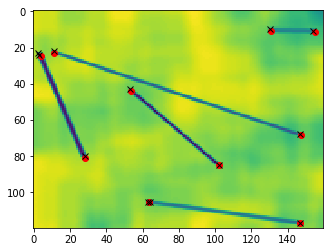

draw_lines_50


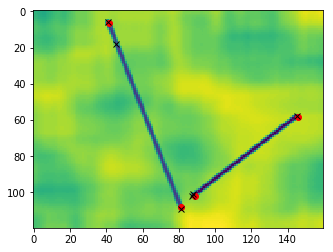

draw_lines_171


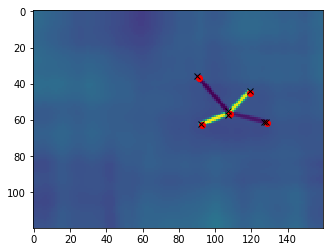

draw_star_176


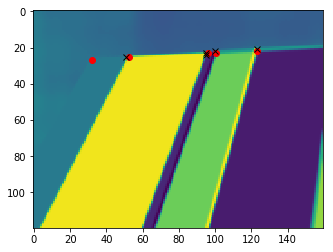

draw_stripes_150


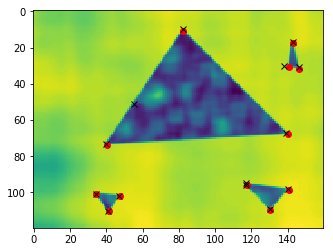

draw_multiple_polygons_181


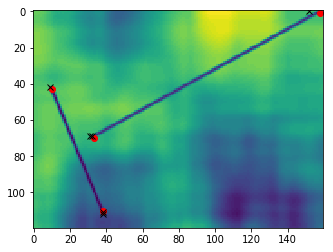

draw_lines_124


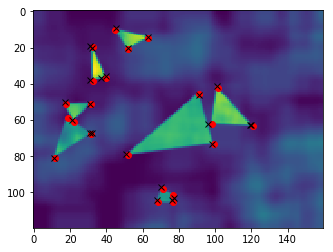

draw_multiple_polygons_88


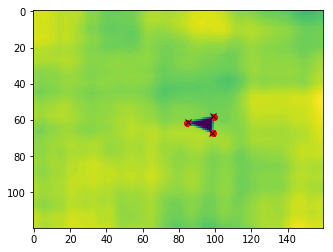

draw_polygon_57


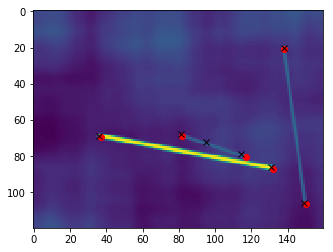

draw_lines_191


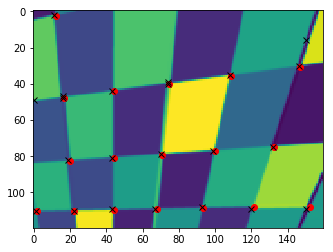

draw_checkerboard_33


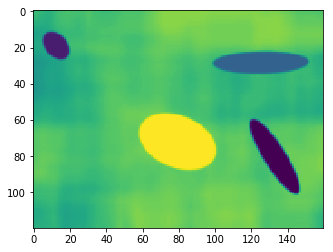

draw_ellipses_186


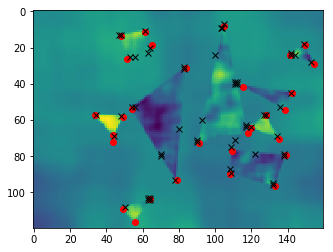

draw_multiple_polygons_169


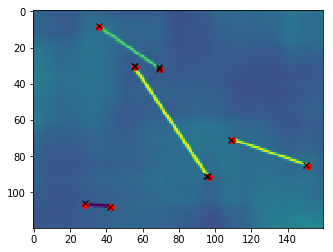

draw_lines_167


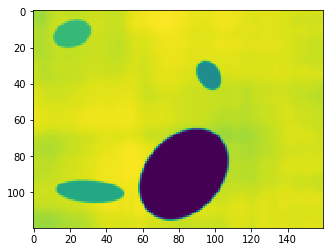

draw_ellipses_9


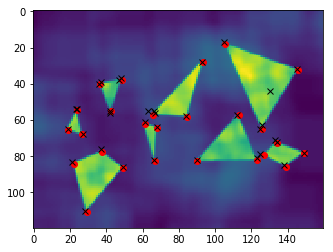

draw_multiple_polygons_46


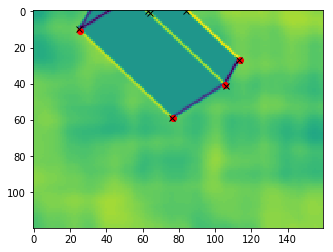

draw_cube_94


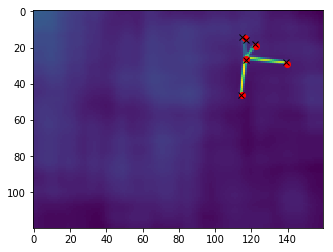

draw_star_190


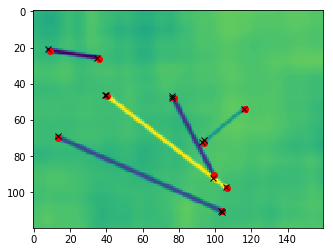

draw_lines_58


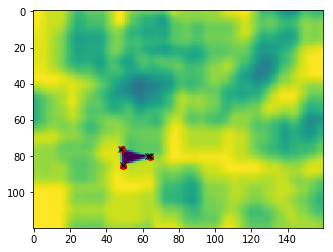

draw_polygon_4


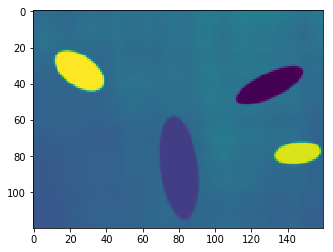

draw_ellipses_187


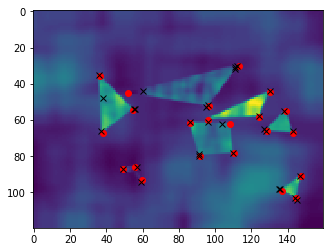

draw_multiple_polygons_44


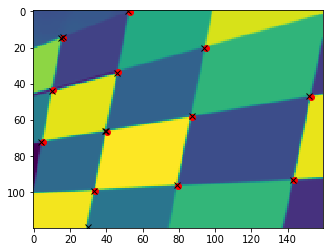

draw_checkerboard_139


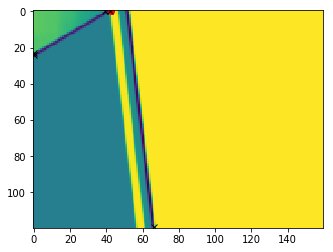

draw_stripes_166


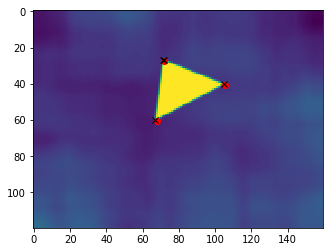

draw_polygon_117


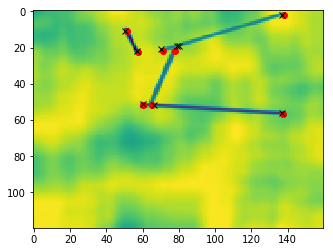

draw_lines_177


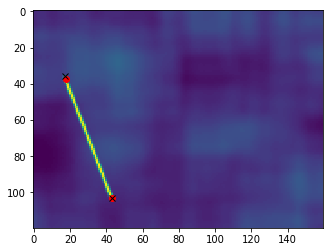

draw_lines_120


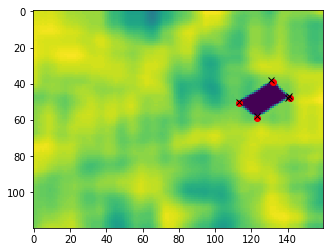

draw_polygon_120


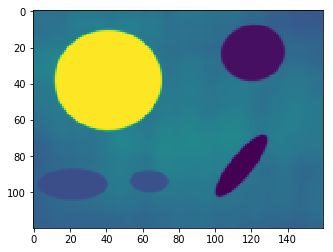

draw_ellipses_30


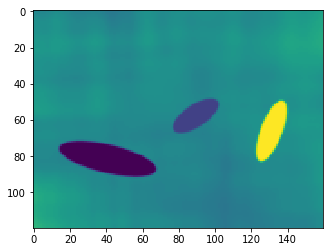

draw_ellipses_160


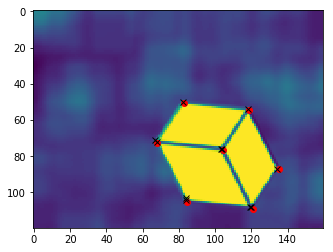

draw_cube_93


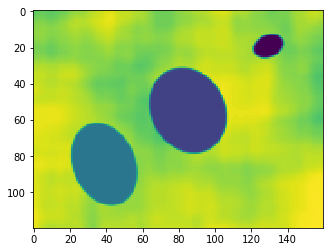

draw_ellipses_109


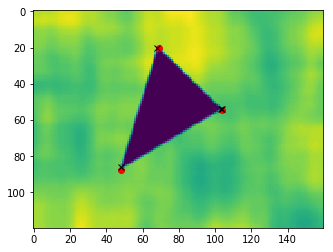

draw_polygon_157


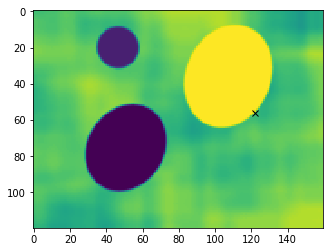

draw_ellipses_87


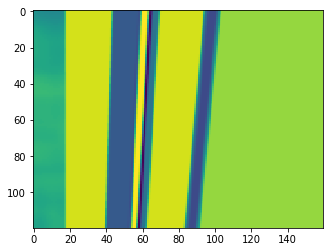

draw_stripes_64


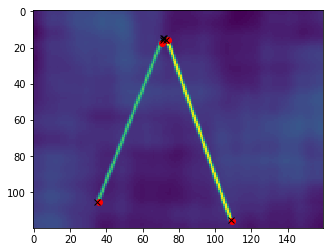

draw_lines_49


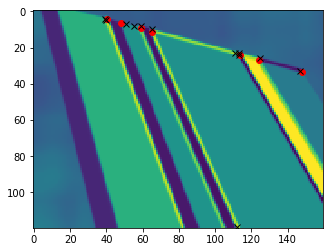

draw_stripes_113


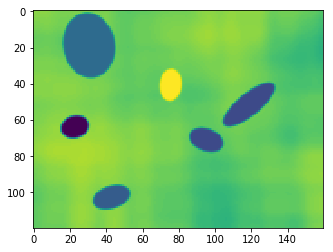

draw_ellipses_80


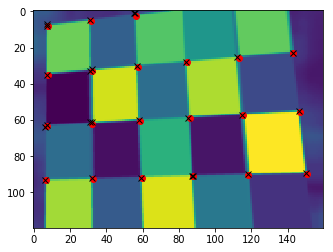

draw_checkerboard_5


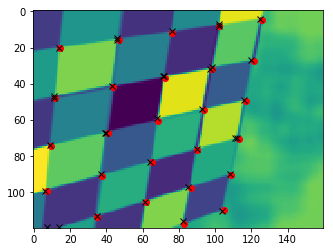

draw_checkerboard_133


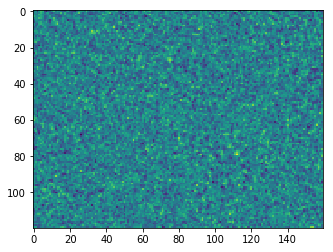

gaussian_noise_174


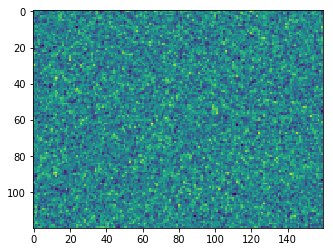

gaussian_noise_151


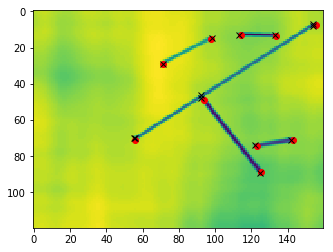

draw_lines_172


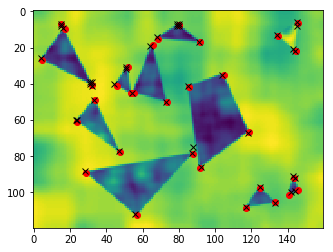

draw_multiple_polygons_190


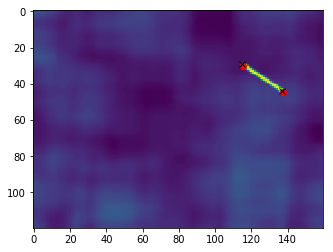

draw_lines_158


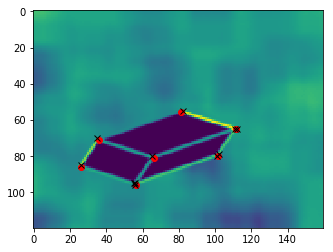

draw_cube_138


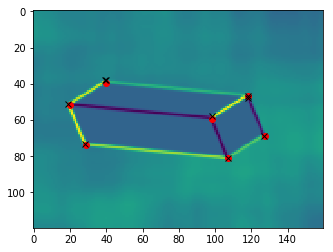

draw_cube_122


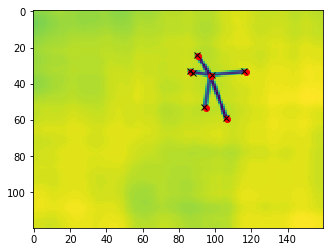

draw_star_110


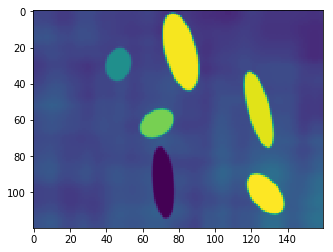

draw_ellipses_138


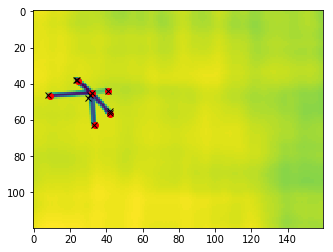

draw_star_186


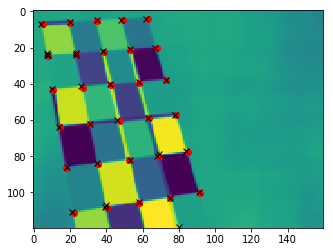

draw_checkerboard_102


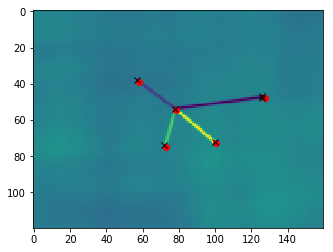

draw_star_8


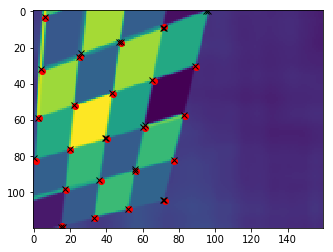

draw_checkerboard_80


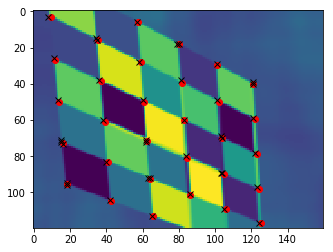

draw_checkerboard_138


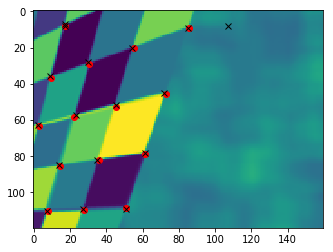

draw_checkerboard_17


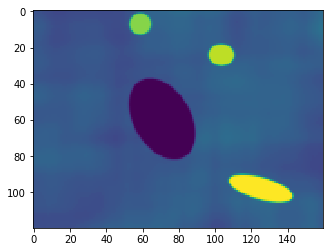

draw_ellipses_33
> <ipython-input-72-7c4545d8b659>(1)<module>()->None
-> for batch_idx, (imgs,pix_locs,didx) in enumerate(val_loader):
(Pdb) q


BdbQuit: 

In [72]:
for batch_idx, (imgs,pix_locs,didx) in enumerate(val_loader):

    h,w = imgs[0].shape
    ipt,desc = model(imgs.float().unsqueeze(1).to(DEVICE))
    #ipt bnum x 65 x hc x wc
    bnum, dims, hc, wc = ipt.shape
    #pdb.set_trace()
    ipt_sm = criterion(ipt)
    #ignore the dustbin entry
    ipt_sm = ipt_sm[:,:-1,:,:]

    #find the max entry and confidence
    idx_conf,idx_locs = ipt_sm.max(dim=1)

    idx_mask = idx_conf > threshold
    #convert this to pixel location
    #for each image in the batch
    fig=plt.figure(figsize=(8, 8))
    columns = 8
    rows = 8
    for b in range(bnum):
        #img = Image.fromarray(data, 'RGB')
        #print('Image:',didx[b])
        #print('Ground truth pixels:')
        #print(pix_locs[b])
        np_pix_locs = np.array(pix_locs[b])
        #fig=plt.figure()
        fig.add_subplot(rows, columns, b+1)
        plt.imshow(imgs[b])
        plt.plot(np_pix_locs[:,1],np_pix_locs[:,0],'or')
        #print('Estimated pixels:')
        px = []
        py = []
        for x in range(hc):
            for y in range(wc):
                
                if idx_mask[b,x,y] == 1:

                    #location in the image
                    x_ = x*8 +(idx_locs[b,x,y]/8)
                    y_ = y*8 + (idx_locs[b,x,y]%8)
                    #print('x:{0} y:{1}'.format(px,py))
                    px.append(x_.item())
                    py.append(y_.item())

        plt.plot(py,px,'xk')            
        plt.show()
        print(didx[b])
    pdb.set_trace()
        

In [71]:
def inference(img_dir, model):

    plant_imgs = os.listdir(img_dir)
    clr_imgs = [Image.open(img_dir+img).resize((400,300),Image.ANTIALIAS) for img in plant_imgs]
    imgs = torch.tensor(np.asarray([np.array(Image.open(img_dir+img).resize((400,300),Image.ANTIALIAS).convert('L')) for img in plant_imgs],dtype='float')).to(DEVICE)  
    #pdb.set_trace()
    h,w = imgs[0].shape
    ipt,desc = model(imgs.float().unsqueeze(1).to(DEVICE))
    #ipt bnum x 65 x hc x wc
    bnum, dims, hc, wc = ipt.shape
    #pdb.set_trace()
    ipt_sm = criterion(ipt)
    #ignore the dustbin entry
    ipt_sm = ipt_sm[:,:-1,:,:]

    #find the max entry and confidence
    idx_conf,idx_locs = ipt_sm.max(dim=1)

    idx_mask = idx_conf > threshold
    #convert this to pixel location
    #for each image in the batch
    for b in range(bnum):

        #print('Ground truth pixels:')
        #print(pix_locs[b])
        #np_pix_locs = np.array(pix_locs[b])
        fig=plt.figure()
        #fig.add_subplot(rows, columns, b+1)
        plt.imshow(clr_imgs[b])
        #plt.hold(True)
        #plt.plot(np_pix_locs[:,1],np_pix_locs[:,0],'or')
        #print('Estimated pixels:')
        px = []
        py = []
        for x in range(hc):
            for y in range(wc):

                if idx_mask[b,x,y] == 1:

                    #location in the image
                    x_ = x*8 +(idx_locs[b,x,y]/8)
                    y_ = y*8 + (idx_locs[b,x,y]%8)
                    px.append(x_.item())
                    py.append(y_.item())
                    #print('x:{0} y:{1}'.format(px,py))
                    #plt.plot(py,px,'xk')

        plt.plot(py,px,'xy')
        print(plant_imgs[b])
        plt.show()


vc_right_031_1481830521.93.png


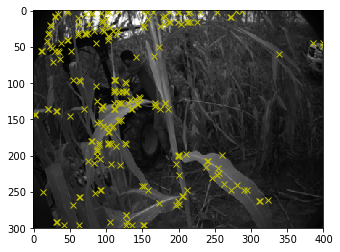

vc_right_042_1481830527.72.png


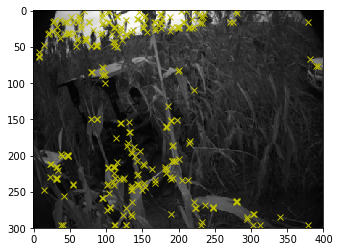

vc_left_019_1481830515.64.png


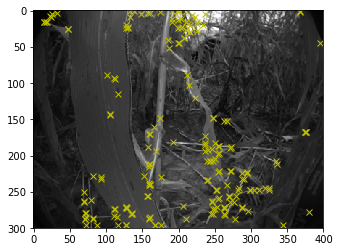

vc_left_015_1481830513.55.png


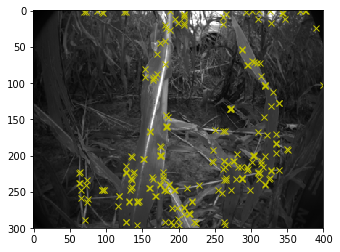

qc_left_br_038_1481830525.62.png


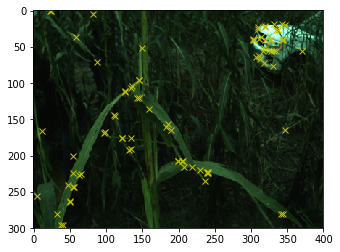

qc_left_tl_021_1481830516.67.png


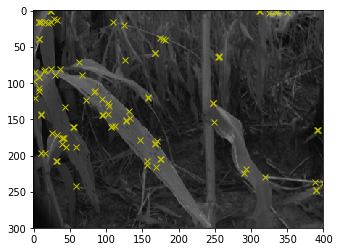

qc_left_tl_024_1481830518.23.png


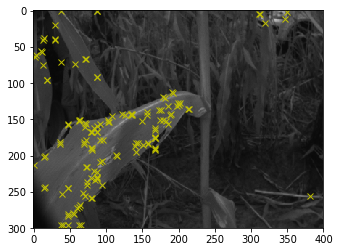

qc_left_tr_005_1481830508.27.png


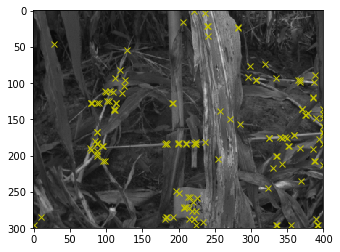

qc_left_tl_012_1481830511.95.png


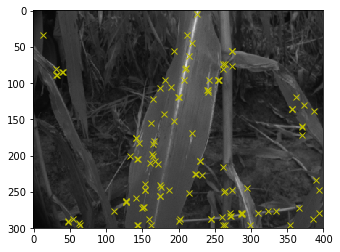

qc_left_tr_011_1481830511.42.png


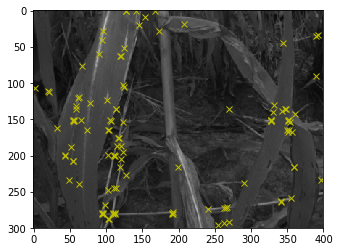

qc_left_br_030_1481830521.45.png


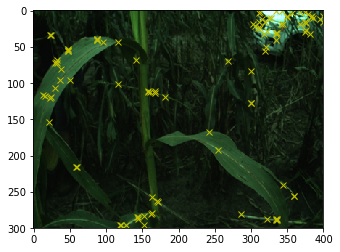

qc_left_br_023_1481830517.76.png


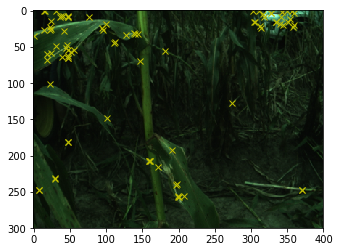

In [74]:
low_res_dir = './datasets/plant_data/test/low_res/'
high_res_dir = './datasets/plant_data/test/high_res/'


inference(high_res_dir,model)
inference(low_res_dir,model)

qc_left_br_038_1481830525.62.png


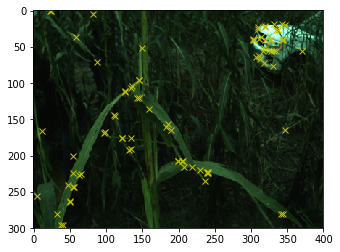

qc_left_tl_021_1481830516.67.png


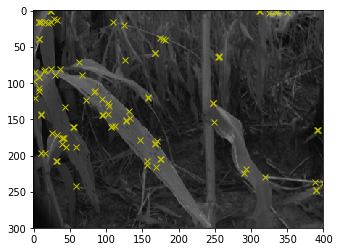

qc_left_tl_024_1481830518.23.png


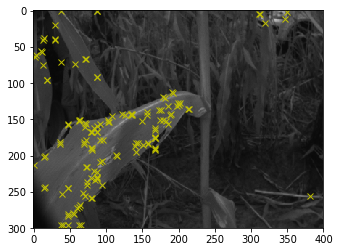

qc_left_tr_005_1481830508.27.png


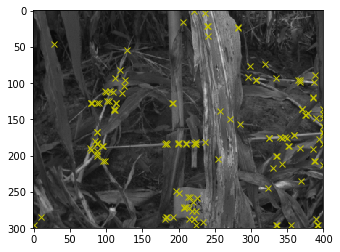

qc_left_tl_012_1481830511.95.png


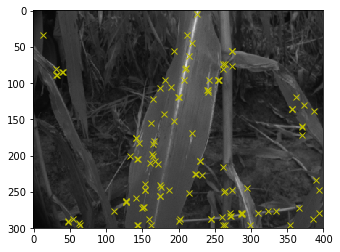

qc_left_tr_011_1481830511.42.png


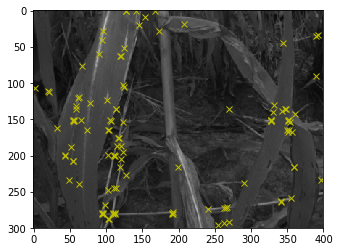

qc_left_br_030_1481830521.45.png


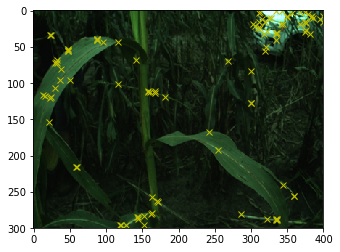

qc_left_br_023_1481830517.76.png


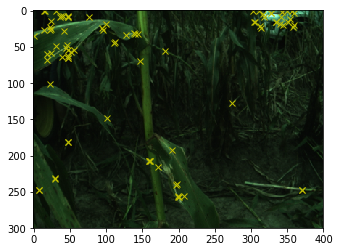

In [75]:
#first epoch model
model_1 = torch.load('Fri Nov  9 15:54:21 2018/e_0_a_177.1913.model')
model_1 = model_1.to(DEVICE)
model_1.eval()
inference(low_res_dir,model_1)


In [20]:
mgs.float().unsqueeze(1).to(DEVICE).shape

NameError: name 'mgs' is not defined

qc_left_br_038_1481830525.62.png


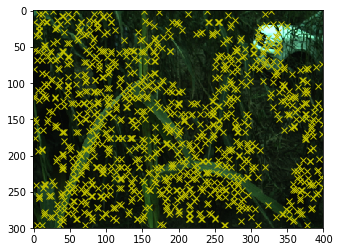

qc_left_tl_021_1481830516.67.png


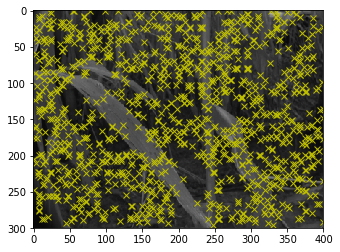

qc_left_tl_024_1481830518.23.png


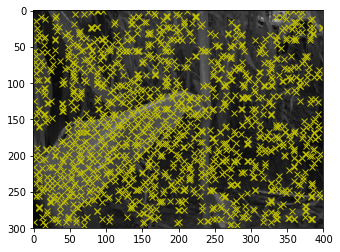

qc_left_tr_005_1481830508.27.png


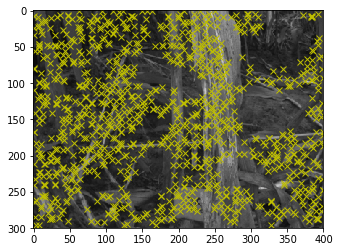

qc_left_tl_012_1481830511.95.png


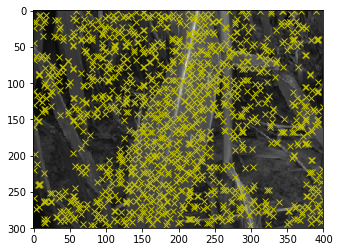

qc_left_tr_011_1481830511.42.png


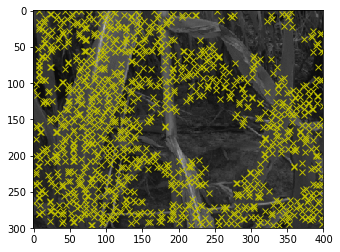

qc_left_br_030_1481830521.45.png


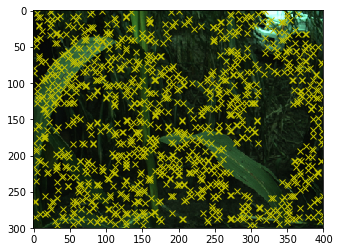

qc_left_br_023_1481830517.76.png


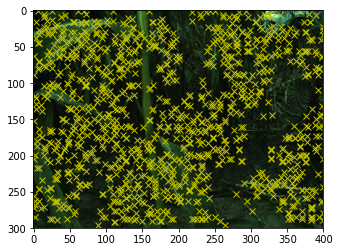

In [76]:
#first epoch model
model_50 = torch.load('Fri Nov  9 15:54:21 2018/e_50_a_16.7367.model')
model_50 = model_50.to(DEVICE)
model_50.eval()
inference(low_res_dir,model_50)


qc_left_br_038_1481830525.62.png


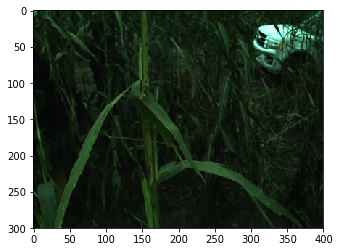

qc_left_tl_021_1481830516.67.png


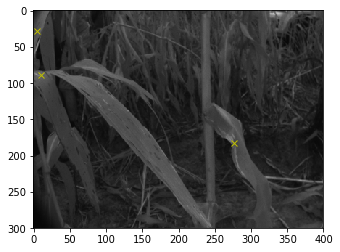

qc_left_tl_024_1481830518.23.png


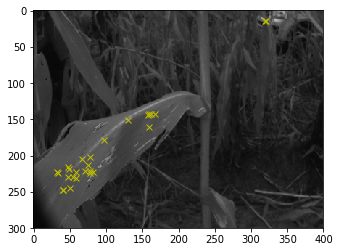

qc_left_tr_005_1481830508.27.png


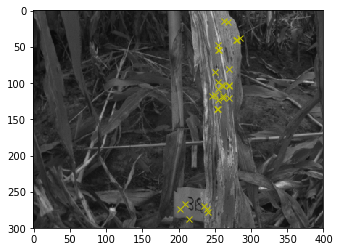

qc_left_tl_012_1481830511.95.png


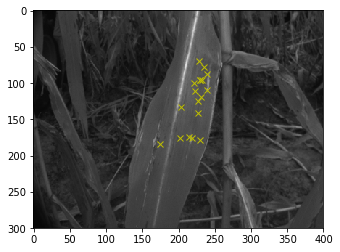

qc_left_tr_011_1481830511.42.png


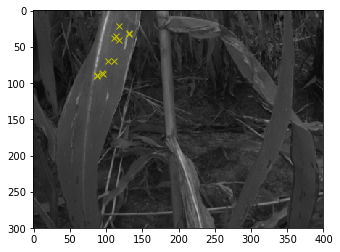

qc_left_br_030_1481830521.45.png


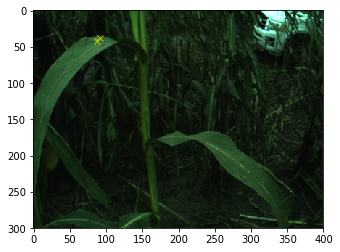

qc_left_br_023_1481830517.76.png


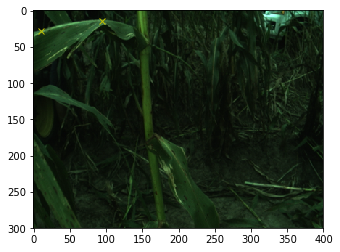

In [59]:
#first epoch model
model_100 = torch.load('Fri Nov  9 15:54:21 2018/e_100_a_14.6325.model')
model_100 = model_100.to(DEVICE)
model_100.eval()
inference(low_res_dir,model_100)


qc_left_br_038_1481830525.62.png


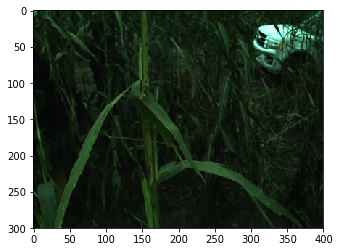

qc_left_tl_021_1481830516.67.png


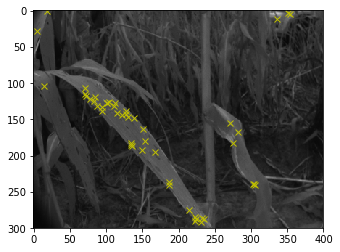

qc_left_tl_024_1481830518.23.png


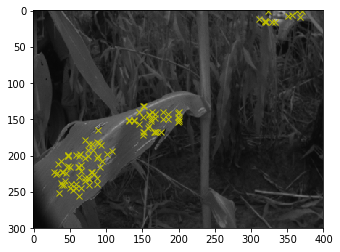

qc_left_tr_005_1481830508.27.png


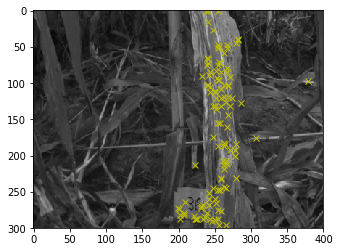

qc_left_tl_012_1481830511.95.png


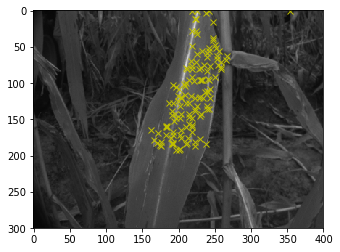

qc_left_tr_011_1481830511.42.png


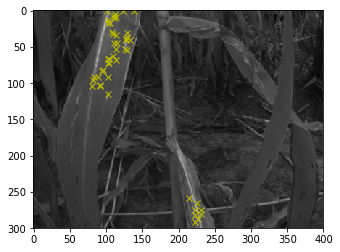

qc_left_br_030_1481830521.45.png


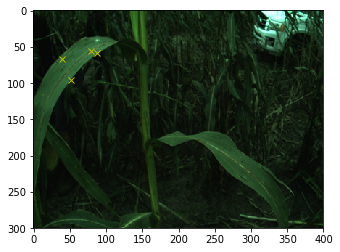

qc_left_br_023_1481830517.76.png


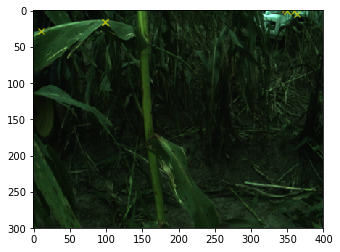

In [56]:
#model at epoch 146
model_146 = torch.load('Fri Nov  9 15:54:21 2018/e_146_a_13.2235.model')
model_146 = model_146.to(DEVICE)
model_146.eval()
inference(low_res_dir,model_146)


qc_left_br_038_1481830525.62.png


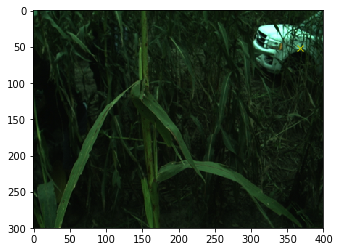

qc_left_tl_021_1481830516.67.png


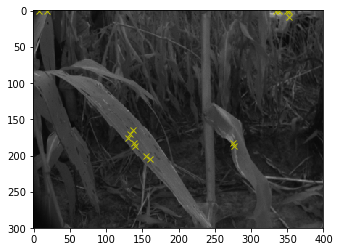

qc_left_tl_024_1481830518.23.png


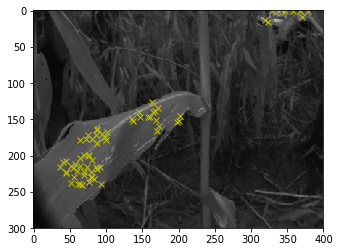

qc_left_tr_005_1481830508.27.png


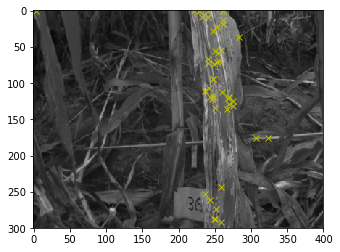

qc_left_tl_012_1481830511.95.png


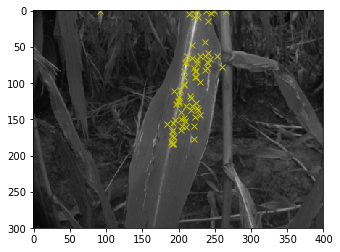

qc_left_tr_011_1481830511.42.png


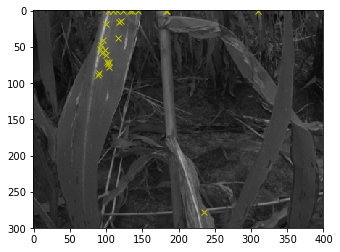

qc_left_br_030_1481830521.45.png


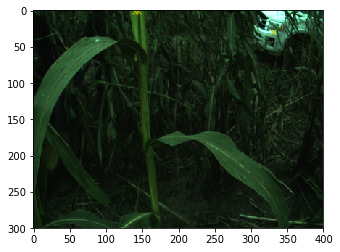

qc_left_br_023_1481830517.76.png


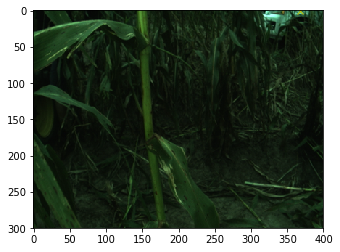

In [58]:
model_406 = torch.load('Fri Nov  9 15:54:21 2018/e_406_a_10.8957.model')
model_406 = model_406.to(DEVICE)
model_406.eval()
inference(low_res_dir,model_406)


In [ ]:
model_1 = torch.load('Fri Nov  9 15:54:21 2018/e_0_a_177.1913.model')
model_1 = model_1.to(DEVICE)
model_1.eval()
inference(low_res_dir,model_1)
